In [164]:
import sys

sys.path.append("C:/Users/11581/UU/mobile_phone")

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.")
from datetime import timedelta


from sklearn.preprocessing import MinMaxScaler, StandardScaler, quantile_transform

import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

In [267]:
long_flow = pd.read_csv('C:/Users/11581/OneDrive/桌面/data/long_flow.csv')
short_flow = pd.read_csv('C:/Users/11581/OneDrive/桌面/data/short_flow.csv')
district_distance = pd.read_csv('C:/Users/11581/OneDrive/桌面/data/district_distance.csv')
districts_gdf = pd.read_csv('C:/Users/11581/OneDrive/桌面/data/districts_gdf.csv')
radiation_features = pd.read_csv('C:/Users/11581/OneDrive/桌面/data/radiation_features.csv')
sci = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/sci.csv')
city = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/city.csv')
city_distance = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/city_distance.csv')

In [204]:
bins1 = [0, 42, 146,  float('inf')]  
labels1 = [1, 2, 3]  

district_distance['category1'] = pd.cut(district_distance['distance'], bins=bins1, labels=labels1, right=False)
district_distance['distance_zscore'] = (district_distance['distance'] - district_distance['distance'].mean()) / district_distance['distance'].std()
district_distance['distance_log'] = 1 / (1 + np.exp(-district_distance['distance_zscore']))

##calculating features based on  category
bins2 = [0, 42, 146,  float('inf')]  
labels2 = [1, 2, 3]  

city_distance['category1'] = pd.cut(city_distance['distance'], bins=bins2, labels=labels2, right=False)
city_distance['distance_zscore'] = (city_distance['distance'] - city_distance['distance'].mean()) / city_distance['distance'].std()

city_distance['distance_log'] = 1 / (1 + np.exp(-city_distance['distance_zscore']))
#print(city_distance)

In [168]:
#sci_log
sci['zscore_scaled'] = (sci['scaled_sci'] - sci['scaled_sci'].mean()) / sci['scaled_sci'].std()

sci['sci_log'] = 1 / (1 + np.exp(-sci['zscore_scaled']))

In [169]:
#calculating features based on km

In [170]:
#calculate gravity-inspired transformation
def create_district_values_dict(df):
    return df.set_index('district').to_dict(orient='index')

def calculate_w1(ua, ub):
    return ua * ub

def calculate_w2(ua, ub, distance_km):
    return ua * ub / distance_km if distance_km != 0 else 0

def calculate_w3(ua, ub, distance_km):
    return ua * ub / (distance_km ** 2) if distance_km != 0 else 0

In [ ]:
def calculate_w11(ua):
    return ua

def calculate_w21(ua, distance_km):
    return ua  / distance_km if distance_km != 0 else 0

def calculate_w31(ua, distance_km):
    return ua  / (distance_km ** 2) if distance_km != 0 else 0

In [ ]:
def create_district_values_dict(df):
    return df.set_index('district').to_dict(orient='index')

def merge_sci_city_distance(sci, city_distance):
    merged_df = pd.merge(sci, city_distance, left_on=['user_loc', 'fr_loc'], right_on=['city_1', 'city_2'], how='left')
    
    merged_df = pd.merge(merged_df, city_distance, left_on=['user_loc', 'fr_loc'], right_on=['city_2', 'city_1'], how='left', suffixes=('', '_reverse'))
    
    merged_df['distance'] = merged_df['distance'].fillna(merged_df['distance_reverse'])
    
    return merged_df

In [171]:
def add_sci_columns(sci, city_distance):
    merged_df = merge_sci_city_distance(sci, city_distance)
    merged_df['distance'] = merged_df['distance'].fillna(50)
    merged_df['category1'] = merged_df['category1'].fillna(1)
    merged_df['distance_log'] = merged_df['distance_log'].fillna(0.16)

    merged_df['sci1'] = merged_df.apply(lambda row: calculate_w11(row['scaled_sci']), axis=1)
    merged_df['sci2'] = merged_df.apply(lambda row: calculate_w21(row['scaled_sci'], row['distance']), axis=1)
    merged_df['sci3'] = merged_df.apply(lambda row: calculate_w31(row['scaled_sci'], row['distance']), axis=1)
    merged_df['sci2_category'] = merged_df.apply(lambda row: calculate_w21(row['sci_log'], row['category1']), axis=1)
    merged_df['sci3_category'] = merged_df.apply(lambda row: calculate_w31(row['sci_log'], row['category1']), axis=1)
    merged_df['sci2_log'] = merged_df.apply(lambda row: calculate_w21(row['sci_log'], row['distance_log']), axis=1)
    merged_df['sci3_log'] = merged_df.apply(lambda row: calculate_w31(row['sci_log'], row['distance_log']), axis=1)
    
    return merged_df

sci_df = add_sci_columns(sci, city_distance)

#print(sci_df)

In [173]:
feature_names = ['healthcare', 'damaged_buildings_ratio', 'population', 'intensity', 'rwi']

def generate_features(distance_df, district_gdf, distance_column):
    district_values = create_district_values_dict(district_gdf)
    
    features1 = []
    features2 = []
    features3 = []

    for _, row in distance_df.iterrows():
        district_1 = row['district_1']
        district_2 = row['district_2']
        distance = row[distance_column] 

        if district_1 in district_values and district_2 in district_values:
            uA_values = district_values[district_1]
            uB_values = district_values[district_2]

            feature1_row = {'district_1': district_1, 'district_2': district_2}
            feature2_row = {'district_1': district_1, 'district_2': district_2}
            feature3_row = {'district_1': district_1, 'district_2': district_2}

            for feature in feature_names:
                feature1_row[feature] = calculate_w1(uA_values[feature], uB_values[feature])
                feature2_row[feature] = calculate_w2(uA_values[feature], uB_values[feature], distance)
                feature3_row[feature] = calculate_w3(uA_values[feature], uB_values[feature], distance)

            features1.append(feature1_row)
            features2.append(feature2_row)
            features3.append(feature3_row)

    features_km1 = pd.DataFrame(features1)
    features_km2 = pd.DataFrame(features2)
    features_km3 = pd.DataFrame(features3)

    return features_km1, features_km2, features_km3

In [174]:
features_km1, features_km2, features_km3 = generate_features(district_distance, districts_gdf,'distance')

#print("km1:\n", features_km1.head())
#print("km2:\n", features_km2.head())
#print("km3:\n", features_km3.head())

In [175]:
#adding sci into features
for features in [features_km1, features_km2, features_km3]:
    features[['city_1', 'region_1']] = features['district_1'].str.split('_', expand=True)
    features[['city_2', 'region_2']] = features['district_2'].str.split('_', expand=True)

features_km1 = pd.merge(features_km1, sci_df[['user_loc', 'fr_loc', 'sci1']], 
                        left_on=['city_1', 'city_2'], right_on=['user_loc', 'fr_loc'], 
                        how='left').drop(['user_loc', 'fr_loc'], axis=1)
features_km1.rename(columns={'sci1': 'sci'}, inplace=True)

features_km2 = pd.merge(features_km2, sci_df[['user_loc', 'fr_loc', 'sci2']], 
                        left_on=['city_1', 'city_2'], right_on=['user_loc', 'fr_loc'], 
                        how='left').drop(['user_loc', 'fr_loc'], axis=1)
features_km2.rename(columns={'sci2': 'sci'}, inplace=True)

features_km3 = pd.merge(features_km3, sci_df[['user_loc', 'fr_loc', 'sci3']], 
                        left_on=['city_1', 'city_2'], right_on=['user_loc', 'fr_loc'], 
                        how='left').drop(['user_loc', 'fr_loc'], axis=1)
features_km3.rename(columns={'sci3': 'sci'}, inplace=True)

In [176]:
#normalizing functions
def apply_minmax(df, columns, district_columns=['district_1', 'district_2']):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)
    return pd.concat([df[district_columns].copy(), df_scaled], axis=1)

def apply_zscore(df, columns, district_columns=['district_1', 'district_2']):
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)
    return pd.concat([df[district_columns].copy(), df_scaled], axis=1)

def apply_logistic_zscore(df, columns, district_columns=['district_1', 'district_2']):
    zscore_scaled = apply_zscore(df, columns, district_columns)[columns]  
    logistic_scaled = 1 / (1 + np.exp(-zscore_scaled)) 
    return pd.concat([df[district_columns].copy(), logistic_scaled], axis=1)

def apply_percentile(df, columns, district_columns=['district_1', 'district_2']):
    percentile_scaled = pd.DataFrame(quantile_transform(df[columns], output_distribution='uniform'), columns=columns)
    return pd.concat([df[district_columns].copy(), percentile_scaled], axis=1)

In [177]:
normalization_methods = {
    'log': apply_logistic_zscore,
}

features_km_dict = {
    'features_km1': features_km1,
    'features_km2': features_km2,
    'features_km3': features_km3
}

features_dict = {}

for km_key, km_data in features_km_dict.items():
    for method_name, method_func in normalization_methods.items():
        norm_key = f'{km_key}_{method_name}'
        features_dict[norm_key] = method_func(km_data, columns_to_normalize, ['district_1', 'district_2'])

for norm_key, norm_data in features_dict.items():
    print(f"{norm_key}:\n", norm_data.head())

features_km1_log:
        district_1        district_2       sci  damaged_buildings_ratio  \
0  ISTANBUL_SISLI       IZMIR_CIGLI  0.477319                 0.490555   
1  ISTANBUL_SISLI     ISTANBUL_SILE  0.500092                 0.490555   
2  ISTANBUL_SISLI   GUMUSHANE_SIRAN  0.484355                 0.490555   
3  ISTANBUL_SISLI      SIIRT_SIRVAN  0.480078                 0.490555   
4  ISTANBUL_SISLI  CANKIRI_SABANOZU  0.480437                 0.490555   

   healthcare  population  intensity       rwi  
0    0.967925    0.862399   0.290289  0.915725  
1    0.605015    0.548001   0.290289  0.987167  
2    0.492635    0.478328   0.290289  0.165276  
3    0.562441    0.479747   0.290289  0.174738  
4    0.501401    0.461116   0.290289  0.335538  
features_km2_log:
        district_1        district_2       sci  damaged_buildings_ratio  \
0  ISTANBUL_SISLI       IZMIR_CIGLI  0.479461                 0.495008   
1  ISTANBUL_SISLI     ISTANBUL_SILE  0.507839                 0.495008   
2

In [178]:
##calculating features based on  category

In [179]:
# normalizing districts_gdf
columns_to_normalize = ['healthcare', 'damaged_buildings_ratio', 'population', 'intensity', 'rwi']

districts_gdf_log = apply_logistic_zscore(districts_gdf, columns_to_normalize,['district'])

In [181]:
gdf_dict = {
    'log': districts_gdf_log,
}

for key, gdf in gdf_dict.items():
    features_dict[f'features_category1_{key}'], \
    features_dict[f'features_category2_{key}'], \
    features_dict[f'features_category3_{key}'] = generate_features(district_distance, gdf, 'category1')

In [183]:
# adding sci into features
for features in [features_dict['features_category1_log'], features_dict['features_category2_log'], features_dict['features_category3_log']]:
    features[['city_1', 'region_1']] = features['district_1'].str.split('_', expand=True)
    features[['city_2', 'region_2']] = features['district_2'].str.split('_', expand=True)


features_dict['features_category1_log'] = pd.merge(features_dict['features_category1_log'], sci_df[['user_loc', 'fr_loc', 'sci_log']], 
                        left_on=['city_1', 'city_2'], right_on=['user_loc', 'fr_loc'], 
                        how='left').drop(['user_loc', 'fr_loc'], axis=1)
features_dict['features_category1_log'].rename(columns={'sci_log': 'sci'}, inplace=True)

features_dict['features_category2_log'] = pd.merge(features_dict['features_category2_log'], sci_df[['user_loc', 'fr_loc', 'sci2_category']], 
                        left_on=['city_1', 'city_2'], right_on=['user_loc', 'fr_loc'], 
                        how='left').drop(['user_loc', 'fr_loc'], axis=1)
features_dict['features_category2_log'].rename(columns={'sci2_category': 'sci'}, inplace=True)

features_dict['features_category3_log'] = pd.merge(features_dict['features_category3_log'], sci_df[['user_loc', 'fr_loc', 'sci3_category']], 
                        left_on=['city_1', 'city_2'], right_on=['user_loc', 'fr_loc'], 
                        how='left').drop(['user_loc', 'fr_loc'], axis=1)
features_dict['features_category3_log'].rename(columns={'sci3_category': 'sci'}, inplace=True)

In [184]:
#radiation transformed features

In [185]:
normalization_methods = {
    'log': apply_logistic_zscore,
}

for method_name, method_func in normalization_methods.items():
    features_dict[f'features_radiation_{method_name}'] = method_func(
        radiation_features,
        columns_to_normalize,
        district_columns=['district_1', 'district_2']
    )

In [186]:
#short flow

In [187]:
baseline_weeks = short_flow[short_flow['week'].isin(['2023-01-23/2023-01-29', '2023-01-30/2023-02-05'])]

baseline = baseline_weeks.groupby(['week', 'origin_city_district', 'destination_city_district'], as_index=False)['flow_count'].sum()

baseline_avg = baseline.groupby(['origin_city_district', 'destination_city_district'], as_index=False)['flow_count'].mean()

In [189]:
third_week = short_flow[short_flow['week'] == '2023-02-06/2023-02-12']
forth_week = short_flow[short_flow['week'] == '2023-02-13/2023-02-19']

In [190]:
third_week_aggregated = third_week.groupby(
    ['origin_city_district', 'destination_city_district']
)['flow_count'].sum().reset_index()

forth_week_aggregated = forth_week.groupby(
    ['origin_city_district', 'destination_city_district']
)['flow_count'].sum().reset_index()

merged3 = third_week_aggregated.merge(baseline_avg, on=['origin_city_district', 'destination_city_district'], how='left')

In [192]:
merged3['flow_difference'] = merged3.apply(
    lambda row: max(0, row['flow_count_x'] - row['flow_count_y']) 
    if pd.notna(row['flow_count_y']) 
    else row['flow_count_x'], axis=1
)

merged_df3 = pd.merge(
    merged3, 
    districts_gdf[['district', 'intensity']], 
    left_on='origin_city_district', 
    right_on='district', 
    how='left'
)

flow3 = merged_df3[merged_df3['intensity'] > 4.5]

flow3['flow_count'] = np.ceil(flow3['flow_difference'])

flow3 = flow3[['origin_city_district', 'destination_city_district', 'flow_count']]

#print(flow3)

      origin_city_district destination_city_district  flow_count
0             ADANA_ALADAG              ADANA_CEYHAN         1.0
1             ADANA_ALADAG            ADANA_CUKUROVA         0.0
2             ADANA_ALADAG            ADANA_IMAMOGLU         1.0
3             ADANA_ALADAG           ADANA_KARAISALI         2.0
4             ADANA_ALADAG               ADANA_KOZAN         3.0
...                    ...                       ...         ...
14908     YOZGAT_CAYIRALAN           YOZGAT_SARIKAYA         1.0
14913      YOZGAT_SARIKAYA             ADANA_YUREGIR         0.0
14914      YOZGAT_SARIKAYA            CORUM_SUNGURLU         1.0
14915      YOZGAT_SARIKAYA        KIRSEHIR_CICEKDAGI         1.0
14916      YOZGAT_SARIKAYA             KOCAELI_IZMIT         1.0

[10212 rows x 3 columns]


C:\Users\11581\AppData\Local\Temp\ipykernel_10740\3229160190.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow3['flow_count'] = np.ceil(flow3['flow_difference'])


In [194]:
def analyze_flow_count(df, df_name):
    total_rows = len(df)

    range_0 = df[df['flow_count'] == 0]
    range_1 = df[(df['flow_count'] > 0) & (df['flow_count'] <= 1)]
    range_2_10 = df[(df['flow_count'] > 1) & (df['flow_count'] <= 10)]
    range_10_25 = df[(df['flow_count'] > 10) & (df['flow_count'] <= 25)]
    range_25_50 = df[(df['flow_count'] > 25) & (df['flow_count'] <= 50)]
    range_50_100 = df[(df['flow_count'] > 50) & (df['flow_count'] <= 100)]
    range_above_100 = df[df['flow_count'] > 100]

    percent_0 = len(range_0) / total_rows * 100
    percent_1 = len(range_1) / total_rows * 100
    percent_2_10 = len(range_2_10) / total_rows * 100
    percent_10_25 = len(range_10_25) / total_rows * 100
    percent_25_50 = len(range_25_50) / total_rows * 100
    percent_50_100 = len(range_50_100) / total_rows * 100
    percent_above_100 = len(range_above_100) / total_rows * 100

    print(f"\nAnalysis for {df_name}:")
    print(f"Flow count between 0: {percent_0:.2f}%")
    print(f"Flow count between 1: {percent_1:.2f}%")
    print(f"Flow count between 2 and 10: {percent_2_10:.2f}%")
    print(f"Flow count between 10 and 25: {percent_10_25:.2f}%")
    print(f"Flow count between 25 and 50: {percent_25_50:.2f}%")
    print(f"Flow count between 50 and 100: {percent_50_100:.2f}%")
    print(f"Flow count above 100: {percent_above_100:.2f}%")

In [39]:
analyze_flow_count(flow3, "flow3")


Analysis for flow3:
Flow count between 0: 17.07%
Flow count between 1: 47.99%
Flow count between 2 and 10: 28.74%
Flow count between 10 and 25: 3.47%
Flow count between 25 and 50: 1.48%
Flow count between 50 and 100: 0.76%
Flow count above 100: 0.49%


In [53]:
#long-term

In [223]:
merged_df = pd.merge(
    long_flow, 
    districts_gdf[['district', 'intensity']], 
    left_on='origin_city_district', 
    right_on='district', 
    how='left'
)

long1 = merged_df[merged_df['intensity'] > 4.5]


long1 = long1[['origin_city_district', 'destination_city_district', 'flow_count']]

print(long1)

      origin_city_district destination_city_district  flow_count
3             ADANA_SEYHAN          ISTANBUL_MALTEPE           1
8             ADANA_SEYHAN            ANTALYA_ALANYA           2
11      SANLIURFA_AKCAKALE            ANTALYA_ALANYA           1
21          HATAY_ALTINOZU            ANTALYA_ALANYA           4
22        HATAY_ISKENDERUN          ISTANBUL_MALTEPE           1
...                    ...                       ...         ...
33248    KAYSERI_KOCASINAN           KAYSERI_HACILAR           3
33249    KAYSERI_MELIKGAZI           KAYSERI_HACILAR           6
33250    KAYSERI_MELIKGAZI           KAYSERI_HACILAR           1
33251      KAYSERI_HACILAR           KAYSERI_HACILAR          10
33252      KAYSERI_HACILAR           KAYSERI_HACILAR          13

[12581 rows x 3 columns]


In [55]:
#subsampling

In [195]:
intense_districts = districts_gdf[districts_gdf['intensity'] > 4.4]['district']

all_districts = districts_gdf['district']

sample_data = []
for origin in intense_districts:
    possible_destinations = all_districts[all_districts != origin]
    for destination in possible_destinations:
        sample_data.append({'origin_city_district': origin, 'destination_city_district': destination, 'flow_count': 0})

np.random.shuffle(sample_data)  
sample_df = pd.DataFrame(sample_data).head(40000)  

merged_df = pd.merge(sample_df, short_flow[['origin_city_district', 'destination_city_district']], 
                     on=['origin_city_district', 'destination_city_district'], 
                     how='left', 
                     indicator=True)

sample_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

print(sample_df)

       origin_city_district destination_city_district  flow_count
0            KIRSEHIR_MUCUR                MUS_KORKUT           0
1        MALATYA_DOGANSEHIR              ADANA_ALADAG           0
2            KONYA_EMIRGAZI               ELAZIG_PALU           0
3              ELAZIG_MADEN               BOLU_GEREDE           0
4           DIYARBAKIR_EGIL              BITLIS_AHLAT           0
...                     ...                       ...         ...
44214       MALATYA_DARENDE         GAZIANTEP_OGUZELI           0
44219           TOKAT_TOKAT            BOLU_DORTDIVAN           0
44220           HATAY_PAYAS        DIYARBAKIR_KOCAKOY           0
44221        MERSIN_AKDENIZ  TEKIRDAG_MARMARAEREGLISI           0
44222  KAHRAMANMARAS_GOKSUN              USAK_SIVASLI           0

[36920 rows x 3 columns]


In [ ]:
#model training

In [95]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def process_results(results):
    processed_results = {}
    for model_name, feature_results in results.items():
        processed_results[model_name] = {}
        for feature_case, metrics in feature_results.items():
            processed_results[model_name][feature_case] = {
                'R2': np.mean(metrics['r2']),
                'RMSE': np.mean(metrics['rmse']),
                'MAE': np.mean(metrics['mae']),
                'R2_non_0': np.mean(metrics['r2_non_0']),
                'RMSE_non_0': np.mean(metrics['rmse_non_0']),
                'MAE_non_0': np.mean(metrics['mae_non_0']),
                'RMSE_0': np.mean(metrics['rmse_0']),
                'MAE_0': np.mean(metrics['mae_0'])
            }
    return processed_results

In [261]:
def model_evaluation(model_types, features_dict, selected_features, flow, x_features, sample_df, n_values):
    results = {}

    for model_name, model_func in model_types.items():
        print(f"Evaluating model: {model_name}")
        results[model_name] = {}
        
        for n in n_values:
            print(f"Evaluating with {n} samples")
            
            sample_df_n = sample_df.sample(n=n, random_state=42)
            combined_df = pd.concat([flow, sample_df_n], ignore_index=True)

            for feature_case in selected_features:
                if feature_case not in features_dict:
                    print(f"Feature set {feature_case} not found in the features_dict.")
                    continue
                
                print(f"Running for feature set: {feature_case} with n={n}...")

                feature_df = features_dict[feature_case]
                reversed_feature_df = feature_df.copy()
                reversed_feature_df[['district_1', 'district_2']] = feature_df[['district_2', 'district_1']].values

                merged_df = pd.merge(combined_df, feature_df, 
                                     left_on=['origin_city_district', 'destination_city_district'], 
                                     right_on=['district_1', 'district_2'], 
                                     how='left')

                merged_df_reversed = pd.merge(combined_df, reversed_feature_df, 
                                              left_on=['origin_city_district', 'destination_city_district'], 
                                              right_on=['district_1', 'district_2'], 
                                              how='left')

                merged_df = pd.concat([merged_df, merged_df_reversed])
                merged_df = merged_df.dropna()
                
                if model_name == "Tweedie":
                    stratify_y = None  
                else:
                    merged_df['stratify_y'] = pd.cut(
                        merged_df['flow_count'],
                        bins=[-1, 0, float('inf')],
                        labels=[0, 1],  # 0: y=0, 1: y>0
                    )
                    stratify_y = merged_df['stratify_y']

                x = merged_df[x_features]
                y = merged_df['flow_count']

                skf = StratifiedKFold(n_splits=5)
                
                metrics = {
                    'mae': [], 'r2': [], 'rmse': [],
                    'mae_0': [], 'r2_0': [], 'rmse_0': [],
                    'mae_non_0': [], 'r2_non_0': [], 'rmse_non_0': []
                }

                for train_index, test_index in skf.split(x, stratify_y if stratify_y is not None else (y > 0)):
                    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                    model = model_func
                    model.fit(X_train, y_train)

                    y_pred = model.predict(X_test)

                    metrics['mae'].append(mean_absolute_error(y_test, y_pred))
                    metrics['r2'].append(r2_score(y_test, y_pred))
                    metrics['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

                    if model_name != "Tweedie":
                        y_0 = (y_test == 0)
                        if y_0.any():
                            y_test_0, y_pred_0 = y_test[y_0], y_pred[y_0]
                            metrics['mae_0'].append(mean_absolute_error(y_test_0, y_pred_0))
                            metrics['r2_0'].append(r2_score(y_test_0, y_pred_0))
                            metrics['rmse_0'].append(np.sqrt(mean_squared_error(y_test_0, y_pred_0)))

                        y_non_0 = (y_test > 0)
                        if y_non_0.any():
                            y_test_non_0, y_pred_non_0 = y_test[y_non_0], y_pred[y_non_0]
                            metrics['mae_non_0'].append(mean_absolute_error(y_test_non_0, y_pred_non_0))
                            metrics['r2_non_0'].append(r2_score(y_test_non_0, y_pred_non_0))
                            metrics['rmse_non_0'].append(np.sqrt(mean_squared_error(y_test_non_0, y_pred_non_0)))

                results[model_name][f"{feature_case}_n{n}"] = metrics
    
    return process_results(results)


In [264]:
features_list1 = [
    'features_km1_log',
    'features_km2_log',
    'features_km3_log',
    'features_category2_log',
    'features_category3_log',
]
x_features=['intensity','population','damaged_buildings_ratio', 'rwi','sci']

model_types = {
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Tweedie": XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.5)
}


n_values = [0]

results1 = model_evaluation(model_types, features_dict, features_list1, flow3, x_features, sample_df, n_values)
results1

Evaluating model: Random Forest
Evaluating with 0 samples
Running for feature set: features_km1_log with n=0...
Running for feature set: features_km2_log with n=0...
Running for feature set: features_km3_log with n=0...
Running for feature set: features_category2_log with n=0...
Running for feature set: features_category3_log with n=0...
Evaluating model: XGBoost
Evaluating with 0 samples
Running for feature set: features_km1_log with n=0...
Running for feature set: features_km2_log with n=0...
Running for feature set: features_km3_log with n=0...
Running for feature set: features_category2_log with n=0...
Running for feature set: features_category3_log with n=0...
Evaluating model: Tweedie
Evaluating with 0 samples
Running for feature set: features_km1_log with n=0...
Running for feature set: features_km2_log with n=0...
Running for feature set: features_km3_log with n=0...
Running for feature set: features_category2_log with n=0...
Running for feature set: features_category3_log with

C:\Users\11581\anaconda3\envs\geo_env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\11581\anaconda3\envs\geo_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'Random Forest': {'features_km1_log_n0': {'R2': 0.5510747267937736,
   'RMSE': 11.34841707027854,
   'MAE': 3.3793168561931055,
   'R2_non_0': 0.6048788412705564,
   'RMSE_non_0': 11.685054202828166,
   'MAE_non_0': 3.2117399117237126,
   'RMSE_0': 9.046719516817014,
   'MAE_0': 4.193762983233562},
  'features_km2_log_n0': {'R2': 0.5374935173597966,
   'RMSE': 11.453865500242692,
   'MAE': 3.2758548569506454,
   'R2_non_0': 0.6031846897619253,
   'RMSE_non_0': 11.688552134633564,
   'MAE_non_0': 3.112828472009346,
   'RMSE_0': 9.593265267145211,
   'MAE_0': 4.0683357007874275},
  'features_km3_log_n0': {'R2': 0.53690787046641,
   'RMSE': 11.481574122095525,
   'MAE': 3.272383632992864,
   'R2_non_0': 0.6026384400699267,
   'RMSE_non_0': 11.715030358941842,
   'MAE_non_0': 3.106037393507396,
   'RMSE_0': 9.651828969320816,
   'MAE_0': 4.081010511664678},
  'features_category2_log_n0': {'R2': 0.5526069417345381,
   'RMSE': 11.283392021761749,
   'MAE': 3.3152776015365633,
   'R2_non_0':

In [99]:
features_list2 = [
    'features_radiation_log',
]
x_features=['intensity','population','damaged_buildings_ratio', 'rwi','sci']

model_types = {
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Tweedie": XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.5)
}


n_values = [0]

results2 = model_evaluation(model_types, features_dict, features_list1, flow3, x_features, sample_df, n_values)
results2

Evaluating model: XGBoost
Evaluating with 0 samples
Running for feature set: features_radiation_log with n=0...
Evaluating model: Random Forest
Evaluating with 0 samples
Running for feature set: features_radiation_log with n=0...


{'XGBoost': {'features_radiation_log_n0': {'R2': 0.4673067627230013,
   'RMSE': 14.237054132562937,
   'MAE': 4.097460950319462,
   'R2_non_0': 0.5085782490245967,
   'RMSE_non_0': 15.156279246223367,
   'MAE_non_0': 4.123080339555794,
   'RMSE_0': 9.269154986381428,
   'MAE_0': 3.9930143276708776}},
 'Random Forest': {'features_radiation_log_n0': {'R2': 0.5388158837854956,
   'RMSE': 13.169243316428894,
   'MAE': 4.052889009788878,
   'R2_non_0': 0.5818581942231609,
   'RMSE_non_0': 13.947736326307396,
   'MAE_non_0': 4.017733065785885,
   'RMSE_0': 9.11240959521355,
   'MAE_0': 4.195667975711612}}}

In [221]:
#category2 log is the best

In [147]:
features_list1 = [
    'features_km3_log',
]
x_features=['intensity','population','damaged_buildings_ratio', 'rwi','sci']

n_values = [0,5000,10000, 15000, 20000,25000,30000,35000]


results1 = new_model_evaluation_with_tweedie(features_dict, features_list1, flow3, x_features, sample_df, n_values, n_splits=5)
results1

Evaluating model: Tweedie
Evaluating with 0 samples
Running for feature set: features_km3_log with n=0...
Evaluating with 5000 samples
Running for feature set: features_km3_log with n=5000...
Evaluating with 10000 samples
Running for feature set: features_km3_log with n=10000...
Evaluating with 15000 samples
Running for feature set: features_km3_log with n=15000...
Evaluating with 20000 samples
Running for feature set: features_km3_log with n=20000...
Evaluating with 25000 samples
Running for feature set: features_km3_log with n=25000...
Evaluating with 30000 samples
Running for feature set: features_km3_log with n=30000...
Evaluating with 35000 samples
Running for feature set: features_km3_log with n=35000...


{'Tweedie': {'features_km3_log_n0': {'mae': 2.8175329013623616,
   'r2': 0.5634150115941248,
   'rmse': 11.087509428461292},
  'features_km3_log_n5000': {'mae': 2.037804233465237,
   'r2': 0.5785007958583641,
   'rmse': 9.13913454759992},
  'features_km3_log_n10000': {'mae': 1.5950287344884564,
   'r2': 0.5922832432116903,
   'rmse': 7.8653447142172705},
  'features_km3_log_n15000': {'mae': 1.316265608613046,
   'r2': 0.5775475242828915,
   'rmse': 7.1932144033982555},
  'features_km3_log_n20000': {'mae': 1.1115646647275752,
   'r2': 0.5821337718717816,
   'rmse': 6.555601003876068},
  'features_km3_log_n25000': {'mae': 0.9761387353794501,
   'r2': 0.589382607700977,
   'rmse': 6.048587363618553},
  'features_km3_log_n30000': {'mae': 0.8850035684972744,
   'r2': 0.5788921369781945,
   'rmse': 5.731013922267517},
  'features_km3_log_n35000': {'mae': 0.7908463413858083,
   'r2': 0.5672793578013839,
   'rmse': 5.487738083333539}}}

In [236]:
features_dict

{'features_km1_log':               district_1        district_2       sci  damaged_buildings_ratio  \
 0         ISTANBUL_SISLI       IZMIR_CIGLI  0.477319                 0.490555   
 1         ISTANBUL_SISLI     ISTANBUL_SILE  0.500092                 0.490555   
 2         ISTANBUL_SISLI   GUMUSHANE_SIRAN  0.484355                 0.490555   
 3         ISTANBUL_SISLI      SIIRT_SIRVAN  0.480078                 0.490555   
 4         ISTANBUL_SISLI  CANKIRI_SABANOZU  0.480437                 0.490555   
 ...                  ...               ...       ...                      ...   
 472873  ARTVIN_KEMALPASA   AKSARAY_AKSARAY  0.475468                 0.490555   
 472874  ARTVIN_KEMALPASA     AKSARAY_ESKIL  0.475468                 0.490555   
 472875   HAKKARI_DERECIK   AKSARAY_AKSARAY  0.478159                 0.490555   
 472876   HAKKARI_DERECIK     AKSARAY_ESKIL  0.478159                 0.490555   
 472877   AKSARAY_AKSARAY     AKSARAY_ESKIL  0.999992                 0.490555

In [237]:
sample_df_n = sample_df.sample(n=15000, random_state=42)
combined_df = pd.concat([flow3, sample_df_n], ignore_index=True)

In [238]:
feature_df = features_dict['features_km3_log']
reversed_feature_df = feature_df.copy()
reversed_feature_df[['district_1', 'district_2']] = feature_df[['district_2', 'district_1']].values

merged_df = pd.merge(combined_df, feature_df, 
    left_on=['origin_city_district', 'destination_city_district'], 
    right_on=['district_1', 'district_2'], 
    how='left')

merged_df_reversed = pd.merge(combined_df, reversed_feature_df, 
    left_on=['origin_city_district', 'destination_city_district'], 
    right_on=['district_1', 'district_2'], 
    how='left')

merged_df = pd.concat([merged_df, merged_df_reversed])
merged_df = merged_df.dropna()

In [239]:
def best_parameters(flow, x_features):
    # Initialize result storage
    results = {
        "Tweedie": {}  # To store metrics
    }

    param_grid = {
        'max_depth': [5, 6, 7, 8, 9, 10, 11],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.2],
        'alpha': [1],
        'lambda': [1],
        'gamma': [0.1],
    }

    best_params = None
    best_score = -np.inf

    skf = StratifiedKFold(n_splits=5)

    metrics = {
        'mae': [], 'r2': [], 'rmse': [],
    }

    x = flow[x_features]
    y = flow['flow_count']

    for train_index, test_index in skf.split(x, y > 0):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.5)

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                   scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

        grid_search.fit(X_train, y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_

        print("Current Best Parameters:", grid_search.best_params_)
        print("Current Best Score (MAE):", -grid_search.best_score_)

        y_pred = grid_search.predict(X_test)

        metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        metrics['r2'].append(r2_score(y_test, y_pred))
        metrics['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

    results["Tweedie"] = {
        'mae': np.mean(metrics['mae']),
        'r2': np.mean(metrics['r2']),
        'rmse': np.mean(metrics['rmse']),
    }

    print("Final Best Parameters:")
    print(best_params)

    return results, best_params


In [240]:
x_features=['intensity','population','damaged_buildings_ratio', 'rwi','sci']


results1 = best_parameters(merged_df, x_features)
results1

Current Best Parameters: {'alpha': 1, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 400}
Current Best Score (MAE): 1.2990790594358916
Current Best Parameters: {'alpha': 1, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 400}
Current Best Score (MAE): 1.4175647497867334
Current Best Parameters: {'alpha': 1, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 200}
Current Best Score (MAE): 1.4588026202235163
Current Best Parameters: {'alpha': 1, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 400}
Current Best Score (MAE): 1.3896327750078143
Current Best Parameters: {'alpha': 1, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 400}
Current Best Score (MAE): 1.444571371453275
Final Best Parameters:
{'alpha': 1, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 400}


({'Tweedie': {'mae': 1.262843579157069,
   'r2': 0.6045586878949643,
   'rmse': 6.905773260672271}},
 {'alpha': 1,
  'gamma': 0.1,
  'lambda': 1,
  'learning_rate': 0.2,
  'max_depth': 8,
  'n_estimators': 400})

In [58]:
def shap_analyze(flow, x_features):
    results = {
        "Tweedie": {}  # To store metrics
    }

    best_params = {
        'max_depth': 10,
        'n_estimators': 300,
        'learning_rate': 0.2,
        'alpha': 1,
        'lambda': 1,
        'gamma': 0.1
    }

    shap_values_all = None
    y_true_all = [] 
    y_pred_all = []  
            x = merged_df[x_features]
            y = merged_df['flow_count']  
            skf = StratifiedKFold(n_splits=5)

            # Store metrics
            metrics = {
                'mae': [], 'r2': [], 'rmse': [],
            }

            for train_index, test_index in skf.split(x, y > 0): 
                X_train, X_test = x.iloc[train_index], x.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.5, **best_params)

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                y_true_all.extend(y_test)
                y_pred_all.extend(y_pred)

                metrics['mae'].append(mean_absolute_error(y_test, y_pred))
                metrics['r2'].append(r2_score(y_test, y_pred))
                metrics['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

                explainer = shap.Explainer(model, X_train)
                shap_values = explainer(X_train)

                shap_values_all = shap_values 
                best_features = X_train.columns  

            results["Tweedie"][f"{feature_case}_n{n}"] = {
                'mae': np.mean(metrics['mae']),
                'r2': np.mean(metrics['r2']),
                'rmse': np.mean(metrics['rmse']),
            }

    mean_abs_shap_values = np.abs(shap_values_all.values).mean(axis=0)
    top_4_feature_indices = np.argsort(mean_abs_shap_values)[-4:]  
    top_4_features = best_features[top_4_feature_indices]

    print("Top 4 Features Selected based on SHAP Values:")
    print(top_4_features)

    shap.summary_plot(shap_values_all[:, top_4_feature_indices], X_train.iloc[:, top_4_feature_indices],
                      feature_names=top_4_features)

    # Combine y_true and y_pred into a DataFrame
    df_predictions = pd.DataFrame({
        'y_true': y_true_all,
        'y_pred': y_pred_all
    })

    return results, top_4_features, shap_values_all, df_predictions

In [241]:
def shap_analyze(flow, x_features):
    # Initialize result storage
    results = {
        "Tweedie": {}  # To store metrics
    }

    # Use best parameters (from previous optimization)
    best_params = {
        'max_depth': 10,
        'n_estimators': 300,
        'learning_rate': 0.2,
        'alpha': 1,
        'lambda': 1,
        'gamma': 0.1
    }

    # SHAP summary and selection storage
    shap_values_all = None
    y_true_all = []  # To store all true values across folds
    y_pred_all = []  # To store all predicted values across folds

    x = flow[x_features]
    y = flow['flow_count']  # Original target variable

    skf = StratifiedKFold(n_splits=5)

    metrics = {
        'mae': [], 'r2': [], 'rmse': [],
    }

    for train_index, test_index in skf.split(x, y > 0):  # For Tweedie, no stratification, using y > 0
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.5, **best_params)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        metrics['r2'].append(r2_score(y_test, y_pred))
        metrics['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_train)

        shap_values_all = shap_values 
        best_features = X_train.columns  
    results["Tweedie"] = {
        'mae': np.mean(metrics['mae']),
        'r2': np.mean(metrics['r2']),
        'rmse': np.mean(metrics['rmse']),
    }

    mean_abs_shap_values = np.abs(shap_values_all.values).mean(axis=0)
    top_4_feature_indices = np.argsort(mean_abs_shap_values)[-4:]  
    top_4_features = best_features[top_4_feature_indices]

    print("Top 4 Features Selected based on SHAP Values:")
    print(top_4_features)

    shap.summary_plot(shap_values_all[:, top_4_feature_indices], X_train.iloc[:, top_4_feature_indices],
                      feature_names=top_4_features)

    df_predictions = pd.DataFrame({
        'y_true': y_true_all,
        'y_pred': y_pred_all
    })

    return results, top_4_features, shap_values_all, df_predictions


100%|===================| 20093/20168 [01:37<00:00]        

Top 4 Features Selected based on SHAP Values:
Index(['intensity', 'rwi', 'sci', 'population'], dtype='object')


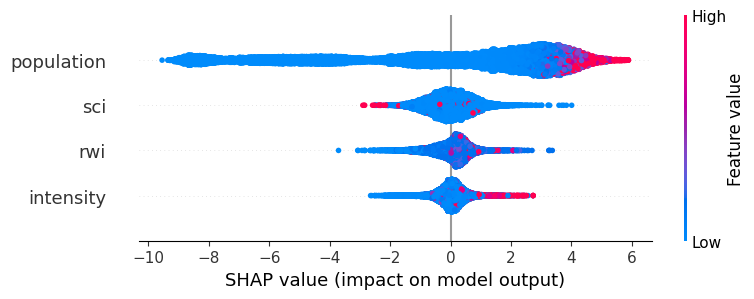

({'Tweedie': {'mae': 1.2603103102047948,
   'r2': 0.5993237506325795,
   'rmse': 6.9283397279200845}},
 Index(['intensity', 'rwi', 'sci', 'population'], dtype='object'),
 .values =
 array([[ 2.48200287e-01,  3.51592595e+00, -8.60170806e-03,
         -6.89824206e-01,  8.27249786e-02],
        [-3.36767573e-01,  4.00924997e+00, -6.65197287e-02,
         -1.14574402e-01, -2.40722209e-01],
        [ 8.14743899e-01,  2.94951413e+00, -6.86079324e-02,
         -2.10017056e-01, -3.88266938e-02],
        ...,
        [-1.20390203e-02, -6.27882505e+00,  1.17330687e-01,
         -7.66814176e-03, -7.03459747e-01],
        [ 2.20892810e-01,  8.48280780e-01,  1.83854880e-01,
         -1.27433391e-01, -6.20261886e-01],
        [-1.35389475e-01,  1.83472690e+00,  1.55069114e-01,
          3.46365434e-03, -2.51276062e-01]])
 
 .base_values =
 array([-3.43057053, -3.43057053, -3.43057053, ..., -3.43057053,
        -3.43057053, -3.43057053])
 
 .data =
 array([[0.9015734 , 0.49668558, 0.49834484, 0.49607

In [243]:
x_features=['intensity','population','damaged_buildings_ratio', 'rwi','sci']

results1 = shap_analyze(merged_df, x_features)
results1

In [62]:
df_predictions = results1.get("df_predictions")
df_predictions = results1[3] 

print(df_predictions.head())

print(df_predictions.head())


AttributeError: 'tuple' object has no attribute 'get'

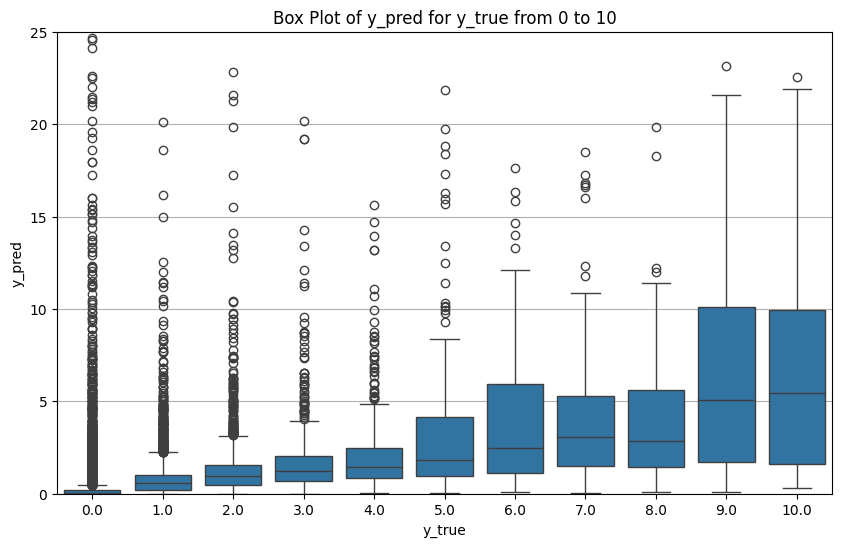

In [68]:
filtered_df = df_predictions[(df_predictions['y_true'] >= 0) & (df_predictions['y_true'] <= 10)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='y_true', y='y_pred', data=filtered_df)

plt.title('Box Plot of y_pred for y_true from 0 to 10')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.ylim(0, 25)

plt.xticks(range(0, 11))  
plt.grid(axis='y')
plt.show()

In [69]:
count_y_true_0_and_y_pred_0 = df_predictions[(df_predictions['y_true'] == 0) & (df_predictions['y_pred'] == 0)].shape[0]

print(f": {count_y_true_0_and_y_pred_0}")


y_true 为 0 的情况下，y_pred 也为 0 的数量: 0


In [ ]:
#gravity model 
#baseline model 1

In [207]:
swapped_districts = district_distance[['district_1', 'district_2', 'distance', 'distance_log']].copy()
swapped_districts.rename(columns={'district_1': 'district_2', 'district_2': 'district_1'}, inplace=True)

district_distance_extended = pd.concat([district_distance, swapped_districts], ignore_index=True)

print(district_distance_extended)

             district_1        district_2     distance category1  \
0        ISTANBUL_SISLI       IZMIR_CIGLI   342.197158         3   
1        ISTANBUL_SISLI     ISTANBUL_SILE    54.440682         2   
2        ISTANBUL_SISLI   GUMUSHANE_SIRAN   909.123380         3   
3        ISTANBUL_SISLI      SIIRT_SIRVAN  1256.953900         3   
4        ISTANBUL_SISLI  CANKIRI_SABANOZU   385.869648         3   
...                 ...               ...          ...       ...   
945751  AKSARAY_AKSARAY  ARTVIN_KEMALPASA   789.103639       NaN   
945752    AKSARAY_ESKIL  ARTVIN_KEMALPASA   835.770045       NaN   
945753  AKSARAY_AKSARAY   HAKKARI_DERECIK  1012.504536       NaN   
945754    AKSARAY_ESKIL   HAKKARI_DERECIK  1060.077238       NaN   
945755    AKSARAY_ESKIL   AKSARAY_AKSARAY    49.478846       NaN   

        distance_zscore  distance_log  
0             -0.739147      0.323191  
1             -1.583474      0.170304  
2              0.924313      0.715920  
3              1.944908

In [86]:
flow5 = pd.merge(flow3, district_distance_extended[['district_1', 'district_2', 'distance']], 
                 left_on=['origin_city_district', 'destination_city_district'], 
                 right_on=['district_2', 'district_1'], 
                 how='left')\
          .drop(columns=['district_1', 'district_2'])


In [87]:
flow5 = pd.merge(flow5, districts_gdf[['district', 'population']], 
                 left_on='origin_city_district', right_on='district', how='left')\
          .rename(columns={'population': 'population_1'})\
          .drop(columns=['district'])

flow5 = pd.merge(flow5, districts_gdf[['district', 'population']], 
                 left_on='destination_city_district', right_on='district', how='left')\
          .rename(columns={'population': 'population_2'})\
          .drop(columns=['district'])

In [92]:
flow5 = flow5.dropna()

print(flow5)

      origin_city_district destination_city_district  flow_count    distance  \
0             ADANA_ALADAG              ADANA_CEYHAN         1.0   77.248621   
1             ADANA_ALADAG            ADANA_CUKUROVA         0.0   58.216720   
2             ADANA_ALADAG            ADANA_IMAMOGLU         1.0   40.987542   
3             ADANA_ALADAG           ADANA_KARAISALI         2.0   36.087641   
4             ADANA_ALADAG               ADANA_KOZAN         3.0   41.732997   
...                    ...                       ...         ...         ...   
10207     YOZGAT_CAYIRALAN           YOZGAT_SARIKAYA         1.0   33.895384   
10208      YOZGAT_SARIKAYA             ADANA_YUREGIR         0.0  312.062693   
10209      YOZGAT_SARIKAYA            CORUM_SUNGURLU         1.0  128.383056   
10210      YOZGAT_SARIKAYA        KIRSEHIR_CICEKDAGI         1.0   96.285682   
10211      YOZGAT_SARIKAYA             KOCAELI_IZMIT         1.0  503.464224   

       population_1  population_2  
0  

In [94]:
def gravity_model(X, alpha, beta, gamma, K):
    population_1, population_2, distance = X
    return K * (population_1 ** alpha) * (population_2 ** gamma) / (distance ** beta)

population_1 = flow5['population_1'].values
population_2 = flow5['population_2'].values
distance = flow5['distance'].values
flow_count = flow5['flow_count'].values

popt, pcov = curve_fit(gravity_model, (population_1, population_2, distance), flow_count, p0=[1, 1, 1, 1])
alpha, beta, gamma, K = popt

print(f"Estimated parameters: alpha={alpha}, beta={beta}, gamma={gamma}, K={K}")

flow5['predicted_flow'] = gravity_model((population_1, population_2, distance), alpha, beta, gamma, K)

r2 = r2_score(flow5['flow_count'], flow5['predicted_flow'])
rmse = np.sqrt(mean_squared_error(flow5['flow_count'], flow5['predicted_flow']))
mae = mean_absolute_error(flow5['flow_count'], flow5['predicted_flow'])

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

Estimated parameters: alpha=0.1797372642926242, beta=1.134672740166601, gamma=0.30036143207583943, K=4.616202966000395
R^2: 0.14846890449422045
RMSE: 15.949942699071876
MAE: 4.487238674053113


C:\Users\11581\AppData\Local\Temp\ipykernel_20368\275240937.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow5['predicted_flow'] = gravity_model((population_1, population_2, distance), alpha, beta, gamma, K)


In [ ]:
#baseline model 2

In [208]:
flow7 = pd.merge(flow3, district_distance_extended[['district_1', 'district_2', 'distance_log']], 
                 left_on=['origin_city_district', 'destination_city_district'], 
                 right_on=['district_2', 'district_1'], 
                 how='left')\
          .drop(columns=['district_1', 'district_2'])

In [209]:
# 拆分 origin_city_district 和 destination_city_district
flow7[['origin_city', 'origin_district']] = flow7['origin_city_district'].str.split('_', expand=True)
flow7[['destination_city', 'destination_district']] = flow7['destination_city_district'].str.split('_', expand=True)

print(flow7)


      origin_city_district destination_city_district  flow_count  \
0             ADANA_ALADAG              ADANA_CEYHAN         1.0   
1             ADANA_ALADAG            ADANA_CUKUROVA         0.0   
2             ADANA_ALADAG            ADANA_IMAMOGLU         1.0   
3             ADANA_ALADAG           ADANA_KARAISALI         2.0   
4             ADANA_ALADAG               ADANA_KOZAN         3.0   
...                    ...                       ...         ...   
10207     YOZGAT_CAYIRALAN           YOZGAT_SARIKAYA         1.0   
10208      YOZGAT_SARIKAYA             ADANA_YUREGIR         0.0   
10209      YOZGAT_SARIKAYA            CORUM_SUNGURLU         1.0   
10210      YOZGAT_SARIKAYA        KIRSEHIR_CICEKDAGI         1.0   
10211      YOZGAT_SARIKAYA             KOCAELI_IZMIT         1.0   

       distance_log origin_city origin_district destination_city  \
0          0.179970       ADANA          ALADAG            ADANA   
1          0.171875       ADANA          ALADAG

In [210]:
flow7 = pd.merge(flow7, sci_df[['user_loc', 'fr_loc', 'sci_log']], 
                 left_on=['origin_city', 'destination_city'], 
                 right_on=['user_loc', 'fr_loc'], 
                 how='left')\
          .drop(columns=['user_loc', 'fr_loc'])

flow7 = flow7.dropna()


In [211]:
flow7

,origin_city_district,destination_city_district,flow_count,distance_log,origin_city,origin_district,destination_city,destination_district,sci_log
0,ADANA_ALADAG,ADANA_CEYHAN,1.0,0.179970,ADANA,ALADAG,ADANA,CEYHAN,0.621491
1,ADANA_ALADAG,ADANA_CUKUROVA,0.0,0.171875,ADANA,ALADAG,ADANA,CUKUROVA,0.621491
2,ADANA_ALADAG,ADANA_IMAMOGLU,1.0,0.164799,ADANA,ALADAG,ADANA,IMAMOGLU,0.621491
3,ADANA_ALADAG,ADANA_KARAISALI,2.0,0.162829,ADANA,ALADAG,ADANA,KARAISALI,0.621491
4,ADANA_ALADAG,ADANA_KOZAN,3.0,0.165100,ADANA,ALADAG,ADANA,KOZAN,0.621491
...,...,...,...,...,...,...,...,...,...
10207,YOZGAT_CAYIRALAN,YOZGAT_SARIKAYA,1.0,0.161954,YOZGAT,CAYIRALAN,YOZGAT,SARIKAYA,0.999227
10208,YOZGAT_SARIKAYA,ADANA_YUREGIR,0.0,0.304160,YOZGAT,SARIKAYA,ADANA,YUREGIR,0.477258
10209,YOZGAT_SARIKAYA,CORUM_SUNGURLU,1.0,0.203184,YOZGAT,SARIKAYA,CORUM,SUNGURLU,0.499431
10210,YOZGAT_SARIKAYA,KIRSEHIR_CICEKDAGI,1.0,0.188361,YOZGAT,SARIKAYA,KIRSEHIR,CICEKDAGI,0.531464


In [212]:
flow7 = pd.merge(flow7, districts_gdf_log[['district', 'population','damaged_buildings_ratio','intensity','rwi']], 
                 left_on='destination_city_district', right_on='district', how='left')\
          .rename(columns={'population': 'population_2','damaged_buildings_ratio':'damaged_buildings_ratio_2','intensity':'intensity_2','rwi':'rwi_2'})\
          .drop(columns=['district'])
flow7 = pd.merge(flow7, districts_gdf_log[['district', 'population','damaged_buildings_ratio','intensity','rwi']], 
                 left_on='origin_city_district', right_on='district', how='left')\
          .rename(columns={'population': 'population_1','damaged_buildings_ratio':'damaged_buildings_ratio_1','intensity':'intensity_1','rwi':'rwi_1'})\
          .drop(columns=['district'])

In [177]:

X = flow7[['sci_log', 
         'population', 'damaged_buildings_ratio', 'intensity', 'rwi']]
y = flow7['flow_count']

def evaluate_model(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    rmse_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    
    return np.mean(r2_scores), np.mean(rmse_scores), np.mean(mae_scores)

rf_model = RandomForestRegressor(random_state=42)
rf_r2, rf_rmse, rf_mae = evaluate_model(rf_model, X, y)

xgb_model = XGBRegressor(random_state=42)
xgb_r2, xgb_rmse, xgb_mae = evaluate_model(xgb_model, X, y)

print("Random Forest Results:")
print(f"R²: {rf_r2:.4f}, RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}")

print("\nXGBoost Results:")
print(f"R²: {xgb_r2:.4f}, RMSE: {xgb_rmse:.4f}, MAE: {xgb_mae:.4f}")

Random Forest Results:
R²: 0.0016, RMSE: 16.5982, MAE: 4.4643

XGBoost Results:
R²: -0.1365, RMSE: 17.4395, MAE: 4.6750
